Neccessory Library

In [2]:
import numpy as np


Simulation parameter

In [3]:
# Simulation Parameters
T = 100  # Time span for one slot 100ms
mu = 0.02   # Sensing duration ratio
t = mu*T    # Sensing time
# PU = 1       # No. of PU
N = 3       # No. of SU
Pr = 0.5    # Probability of spectrum occupancy
Pd = 0.9    # Probability of detection
Pf = 0.1    # Probability of false alarm
m = np.full(N, 20)      # Battery capacity
Eh = 0.1    # Harvested energy during one slot
Pw = -60    # Primary signal power in dBm
PowerTx = 10**(Pw/10)  # Transmitted power
Nw = -70    # Noise power in dBm
PowerNo = 10**(Nw/10)
g = 10**-5  # Path loss coefficeint 10^(-5)
w = 5e6     # Bandwidth
samples = 50  # No. of sample
# N = SU


In [14]:
10**(Pw/10)


1e-06

Monte Carlo Simulation

In [4]:
# ======== Monte Carlo Simulation ========================
def MCS(t, realiz, kind='ray', variance=2, N=3):
    PU = np.array([0, 0])*1e3                                # PU position
    SU = np.array([[0, 5], [0, 7.5], [0, 1]])*1e3               # SU position

    # samples=round(2*T*w)                                    # No. of samples

    # N = SU
    # PU-SU distance
    d = np.zeros(N)
    for i in range(N):
        d[i] = np.linalg.norm(PU-SU[i, :])

    Y = np.zeros((realiz, N))
    S = np.zeros(realiz)
    SNR = np.zeros((N, realiz))

    for k in range(realiz):
        n = gaussianNoise(PowerNo, samples)
        H = channel(N, d, g, kind, variance, samples)
        X, S[k] = PUtx(samples, PowerTx, Pr, N)
        PU = np.multiply(H.T, X)
        Z = PU + n

        SNR[:, k] = np.mean(np.abs(PU)**2, axis=1)/PowerNo
        Y[k, :] = np.sum(np.abs(Z)**2, axis=1)/(PowerNo*samples)

    meanSNR = np.mean(SNR[:, S == 1], 1)
    meanSNRdB = 10*np.log10(meanSNR)
    return Y, S, meanSNRdB


def PUtx(samples, PowerTx, Pr, N):
    S = 0
    X = np.zeros(samples)
    if (np.random.rand(1) <= Pr):
        S = 1
        X = np.random.randn(samples) * np.sqrt(PowerTx)
    X = np.vstack([X]*N)
    return [X, S]


def gaussianNoise(PowerNo, samples):
    N = 3
    n = np.random.randn(N, samples) * np.sqrt(PowerNo)

    return n


def channel(N, d, g, kind, variance, samples):
    H = np.zeros(N)
    if (kind == 'ray'):
        H = np.sqrt(-2 * variance * np.log(np.random.rand(N)))/np.sqrt(2)
    # elif kind=='nakagami':
    #     m=1.5
    #     omega=1
    #     H = np.sqrt(np.gamrnd(m,omega/m,[N,1]))*np.sqrt(variance)
    # elif kind=='rician':
    #     # for i in range(N)
    #     #     ricChan= comm.RicianChannel("MaximumDopplerShift",
        #      0,"NumSamples",1,"ChannelFiltering",0)
    #     #     H(i,:) = abs(ricChan())
    #     # end
    #     # H=H*sqrt(variance)
    #     pass
    else:
        H = np.ones(N, 1)
    H = np.array(H*g)  # Fading + path-loss (amplitude loss)
    H = np.vstack([H]*samples)
    return H


Dataset generation

In [5]:
X_train, y_train, SNR_train = MCS(t, realiz=250)
X_test, y_test, SNR_test = MCS(t, realiz=50000)


Calculating threshold

In [ ]:
import scipy.special
# Calculate the threshold using incomplete gamma function
threshold = 2*scipy.special.gammaincinv(samples/2, 1 - Pf) / samples

print("Threshold:", threshold)


Markov Chain

In [ ]:
import numpy as np

# Define the transition matrix
transition_matrix = np.array([[0.8, 0.2], [0.5, 0.5]])

# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
stationary_distribution = np.real(
    eigenvectors[:, 0] / np.sum(eigenvectors[:, 0]))

print(eigenvalues)
print(eigenvectors)
# Print the steady-state probabilities
states = ["Sunny", "Rainy"]
for state, probability in zip(states, stationary_distribution):
    print(f"Steady-state probability of {state}: {probability:.3f}")


Algorithm

In [23]:
import numpy as np
from scipy.stats import rayleigh

T = 100       # Time span for one slot (100ms)
mu = 0.02     # Sensing duration ratio
t = mu * T    # Sensing time
PU = 1        # No. of PUs
SU = 3        # No. of SUs
Pr = 0.5      # Probability of spectrum occupancy
Pw = -60      # Primary signal power in dBm
Nw = -70      # Noise power in dBm
g = 10**-5    # Path loss coefficient 10^(-5)
training_samples = 250  # No. of samples
testing_samples = 5000

# X_train = np.zeros((training_samples, SU))   # Array to store received signal energy at SUs
# y_train = np.zeros((training_samples,))      # Array to store PU availability

# X_test = np.zeros((testing_samples, SU))   # Array to store received signal energy at SUs
# y_test = np.zeros((testing_samples,))      # Array to store PU availability

def dataset_gen(samples):
    dataset_X = np.zeros((samples, SU))   # Array to store received signal energy at SUs
    dataset_y = np.zeros((samples,))
    for i in range(samples):
    # Generate random PU availability (0 or 1)
        dataset_y[i] = np.random.choice([0, 1], p=[1 - Pr, Pr])
    
        if dataset_y[i] == 1:
        # Calculate received signal energy at SUs for available PU
            for j in range(SU):
                # Generate Rayleigh-distributed channel gain
                h = rayleigh.rvs(scale=np.sqrt(g/2))
                
                # Calculate received signal energy
                received_signal_energy = 10**(0.1 * (Pw + 10 * np.log10(h)))
                
                # Add AWGN noise
                noise_power = 10**(0.1 * Nw)
                received_signal_energy += np.random.normal(0, np.sqrt(noise_power))
                
                dataset_X[i, j] = received_signal_energy
    return dataset_X, dataset_y

X_train, y_train = dataset_gen(samples=training_samples)
# X_test, y_test = dataset_gen(samples=testing_samples)



In [22]:
noise_power = 10**(0.1 * Nw)
np.random.normal(0, np.sqrt(noise_power))

-0.00023012078530997671

In [27]:
test = np.zeros((10))
result = np.zeros((10))
noise_power = 10**(0.1 * Nw)
PowerTx = 10**(0.1 * Pw)
# n = np.random.randn() * np.sqrt(noise_power)
for i in range(10):
    test[i] = np.random.choice([0, 1], p=[1 - Pr, Pr])
    n = np.random.randn() * np.sqrt(noise_power)
    if test[i] == 1:
        h = rayleigh.rvs(scale=np.sqrt(g/2))
        x = np.random.randn(1) * np.sqrt(PowerTx)
        y = h*x+n
        result[i]=y
    else:
        y = n
        result[i]=y
        
print(test)
print(result)

[1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
[ 9.12647446e-05  9.45454742e-05  7.64527775e-05  8.07886568e-04
 -2.33480817e-04  4.87515574e-04 -2.69050808e-04 -1.82978582e-04
 -7.03164595e-04  2.00604554e-04]


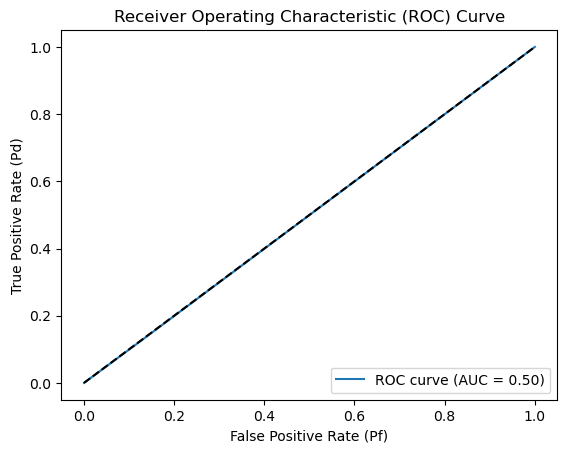

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics

# Create SVM classifier with linear kernel
clf = svm.SVC(kernel='linear')

# Train the model using the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line (random classifier)
plt.xlabel('False Positive Rate (Pf)')
plt.ylabel('True Positive Rate (Pd)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Classification

In [ ]:

plt.plot(fpr,tpr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have the FPR and TPR values for the ROC curve
fpr = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # False Positive Rate
tpr = [0.0, 0.3, 0.5, 0.7, 0.9, 1.0]  # True Positive Rate

# Plotting the ROC curve
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate (Pf)')
plt.ylabel('True Positive Rate (Pd)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Selecting the desired operating point
operating_point_index = 2  # Index of the desired point on the curve

# Calculating Pf and Pd
pf = fpr[operating_point_index]
pd = tpr[operating_point_index]

# Output the results
print("Pf:", pf)
print("Pd:", pd)
